In [1]:
import numpy as np
import GPy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def dataMaker(version):
    df = pd.read_csv ('realData/uq_vsd_case' + version + '_trenddata.csv', error_bad_lines=False, index_col = False )

    df = df.loc[:,['RelativeTimeMilliseconds', 'Pulse', 'RR']]
    
    nan_val = float("NaN")
    df = df.replace("",nan_val)
    df = df.dropna(axis=0, how='any')
    df = df.reset_index(drop=True)

    df = df.loc[:580]

    df['RelativeTimeMilliseconds'] = np.arange(0, 581, 1)

    print(df['RelativeTimeMilliseconds'])
    
    df[['RelativeTimeMilliseconds', 'Pulse', 'RR']] = StandardScaler().fit_transform(df[['RelativeTimeMilliseconds', 'Pulse', 'RR']])

    #StandardScaler().fit_transform(arr['Pulse'].values.reshape(-1, 1))

  
    

    print(df)

    return df


In [3]:
%%capture --no-display

data = []

for i in range(1,33):
    temp = str(i)
    if i < 10:
        data.append(dataMaker('0' + temp))
    elif i in [17,18,19]:
        continue
    else:
        data.append(dataMaker(temp))

#data now contains the first 580 values for each subject with, time, pulse and rr


In [4]:
#here: loop through data list, fit a model for each attibute against time, and save those model (2 in total for each subject) in a separate list. 

#the final list should be a list of list, where the outer list is 32 long and each index contains two models for each subject.

print(len(data))

counter = 0
for item in data:
    counter +=1
    if item.isnull().sum().values.sum() != 0:
        print("version: " , counter)
        print("Data: ")
        print(item.isnull().sum())
        print("-------")

29


In [5]:
def modelMaker(arr):

    X_axis = arr['RelativeTimeMilliseconds'].values.reshape(-1, 1)
    Y_axis = arr['Pulse'].values.reshape(-1, 1)
    Z_axis = arr['RR'].values.reshape(-1, 1)

    #------Y-model------------
    print("Ymodel: ")
    kernelY = GPy.kern.RBF(input_dim=1)
    Ymodel = GPy.models.GPRegression(X_axis, Y_axis, kernelY)

    Ymodel.optimize(messages=True, ipython_notebook=True, clear_after_finish=True)
    Ymodel.optimize_restarts(num_restarts = 2)

    #------Z-model-----------
    print("Zmodel: ")

    kernelZ = GPy.kern.RBF(input_dim=1)
    Zmodel = GPy.models.GPRegression(X_axis, Z_axis, kernelZ)

    Zmodel.optimize(messages=True, ipython_notebook=True, clear_after_finish=True)
    Zmodel.optimize_restarts(num_restarts = 2)

    model = {
        "Ymodel" : Ymodel,
        "Zmodel" : Zmodel
    }

    return model

In [6]:
modelList = []
count = 0
for i in data:
    count = count + 1
    print(count) 
    modelList.append(modelMaker(i))

1
Ymodel: 


Optimization restart 1/2, f = 95.15219381489771
Optimization restart 2/2, f = 95.15219381489874
Zmodel: 


Optimization restart 1/2, f = -37.489394537489545
Optimization restart 2/2, f = -37.48939453752354
2
Ymodel: 


Optimization restart 1/2, f = -141.77037557239163
Optimization restart 2/2, f = -141.7703755725055
Zmodel: 


Optimization restart 1/2, f = -4817.304452190279
Optimization restart 2/2, f = -4817.304455209198
3
Ymodel: 


Optimization restart 1/2, f = 134.22295645255565
Optimization restart 2/2, f = 134.22295645255684
Zmodel: 


Optimization restart 1/2, f = -433.7041787218551
Optimization restart 2/2, f = -454.7583237844987
4
Ymodel: 


Optimization restart 1/2, f = -364.403164726005
Optimization restart 2/2, f = -364.40316472586017
Zmodel: 


Optimization restart 1/2, f = -515.2124046333658
Optimization restart 2/2, f = -472.50533672380396
5
Ymodel: 


Optimization restart 1/2, f = -122.59164239255995
Optimization restart 2/2, f = -122.59164236828553
Zmodel: 


Optimization restart 1/2, f = -553.8548988411673
Optimization restart 2/2, f = -553.8548988397905
6
Ymodel: 


Optimization restart 1/2, f = -317.08968915441267
Optimization restart 2/2, f = -317.08968915473815
Zmodel: 


Optimization restart 1/2, f = -543.7217809843164
Optimization restart 2/2, f = -543.7217809737529
7
Ymodel: 


Optimization restart 1/2, f = -349.28821105750364
Optimization restart 2/2, f = -349.2882110572198
Zmodel: 


Optimization restart 1/2, f = -281.237857022314
Optimization restart 2/2, f = -281.23785702231305
8
Ymodel: 


Optimization restart 1/2, f = -24.650452558093775
Optimization restart 2/2, f = -24.650452558092866
Zmodel: 


Optimization restart 1/2, f = -445.89631667503227
Optimization restart 2/2, f = -435.18457968498944
9
Ymodel: 


Optimization restart 1/2, f = 147.10781803742714
Optimization restart 2/2, f = 147.1078180375021
Zmodel: 


Optimization restart 1/2, f = -395.8889753649592
Optimization restart 2/2, f = -372.8218718907979
10
Ymodel: 


Optimization restart 1/2, f = -119.65367047780705
Optimization restart 2/2, f = 157.4244727996297
Zmodel: 


Optimization restart 1/2, f = -558.4337417253677
Optimization restart 2/2, f = -558.4337417251616
11
Ymodel: 


Optimization restart 1/2, f = -693.2015643725458
Optimization restart 2/2, f = -693.2015643724262
Zmodel: 


Optimization restart 1/2, f = -432.37547804918813
Optimization restart 2/2, f = -432.3754780444933
12
Ymodel: 


Optimization restart 1/2, f = -255.2436335249995
Optimization restart 2/2, f = -255.24363352499358
Zmodel: 


Optimization restart 1/2, f = -53.83614298889739
Optimization restart 2/2, f = -53.83614298881838
13
Ymodel: 


Optimization restart 1/2, f = -355.1554653578835
Optimization restart 2/2, f = -355.1554653578895
Zmodel: 


Optimization restart 1/2, f = -397.3501158685531
Optimization restart 2/2, f = -397.35011586855325
14
Ymodel: 


Optimization restart 1/2, f = -87.81618120001735
Optimization restart 2/2, f = -87.81618119981374
Zmodel: 


Optimization restart 1/2, f = -4817.304452190279
Optimization restart 2/2, f = -4817.30445723947
15
Ymodel: 


Optimization restart 1/2, f = 97.86033453073321
Optimization restart 2/2, f = 97.86033453046889
Zmodel: 


Optimization restart 1/2, f = -4817.304452190279
Optimization restart 2/2, f = -4817.304468326216
16
Ymodel: 


Optimization restart 1/2, f = -463.94036522318567
Optimization restart 2/2, f = -463.940365222012
Zmodel: 


Optimization restart 1/2, f = -423.51135678278
Optimization restart 2/2, f = -423.511356776785
17
Ymodel: 


Optimization restart 1/2, f = -210.5099050481494
Optimization restart 2/2, f = -210.5099050481458
Zmodel: 


Optimization restart 1/2, f = -175.042123843747
Optimization restart 2/2, f = -218.62153473988877
18
Ymodel: 


Optimization restart 1/2, f = 156.74949084049928
Optimization restart 2/2, f = 156.74949084063888
Zmodel: 


Optimization restart 1/2, f = -534.0780243189016
Optimization restart 2/2, f = -534.0780243107326
19
Ymodel: 


Optimization restart 1/2, f = 155.93334329888938
Optimization restart 2/2, f = 155.9333432994759
Zmodel: 


Optimization restart 1/2, f = -694.6222284543403
Optimization restart 2/2, f = -710.4946290181977
20
Ymodel: 


Optimization restart 1/2, f = 178.89841274032335
Optimization restart 2/2, f = 178.89841274031346
Zmodel: 


Optimization restart 1/2, f = -352.4482046232566
Optimization restart 2/2, f = -352.448204622941
21
Ymodel: 


Optimization restart 1/2, f = -685.4949127034033
Optimization restart 2/2, f = -685.494912704022
Zmodel: 


Optimization restart 1/2, f = -632.8092115137058
Optimization restart 2/2, f = -632.8092113939001
22
Ymodel: 


Optimization restart 1/2, f = -295.5760142032359
Optimization restart 2/2, f = -295.5760142044224
Zmodel: 


Optimization restart 1/2, f = -4817.304452190279
Optimization restart 2/2, f = -4817.304451741733
23
Ymodel: 


Optimization restart 1/2, f = -87.68389975222976
Optimization restart 2/2, f = -87.68389975223147
Zmodel: 


Optimization restart 1/2, f = -359.3576196852426
Optimization restart 2/2, f = -380.0486033001181
24
Ymodel: 


Optimization restart 1/2, f = 219.64102090967765
Optimization restart 2/2, f = 219.64102090967725
Zmodel: 


Optimization restart 1/2, f = -4817.304452190279
Optimization restart 2/2, f = -4817.304453277551
25
Ymodel: 


Optimization restart 1/2, f = -429.6671056932773
Optimization restart 2/2, f = -429.6671056932589
Zmodel: 


Optimization restart 1/2, f = -369.6978651481564
Optimization restart 2/2, f = -369.69786514814933
26
Ymodel: 


Optimization restart 1/2, f = -591.1674150939988
Optimization restart 2/2, f = -591.1674150942691
Zmodel: 


Optimization restart 1/2, f = -439.9192876962334
Optimization restart 2/2, f = -439.91928776013714
27
Ymodel: 


Optimization restart 1/2, f = -234.3961719932978
Optimization restart 2/2, f = -234.39617199343206
Zmodel: 


Optimization restart 1/2, f = -567.0556943820196
Optimization restart 2/2, f = -567.0556945459527
28
Ymodel: 


Optimization restart 1/2, f = -334.4632060941419
Optimization restart 2/2, f = -334.4632060918026
Zmodel: 


Optimization restart 1/2, f = -335.30179954642244
Optimization restart 2/2, f = -370.1255435715452
29
Ymodel: 


Optimization restart 1/2, f = -705.2213567598089
Optimization restart 2/2, f = -705.2213567594579
Zmodel: 


Optimization restart 1/2, f = -380.1123927945933
Optimization restart 2/2, f = -352.22777223717316


In [7]:
print(len(modelList))
print(len(data))

29
29


In [69]:
import math

mDim = len(data)
sMatrix = np.empty((mDim, mDim))
sMatrix[:] = np.NaN
test = []
stepper = 10.0 ** 3

for model in range(len(modelList)):

    modelyP = sum(-modelList[model]["Ymodel"].log_predictive_density(data[model]['RelativeTimeMilliseconds']                        .values.reshape(-1,1),data[model]['Pulse'].values.reshape(-1,1)))

    modelzP = sum(-modelList[model]["Zmodel"].log_predictive_density(data[model]['RelativeTimeMilliseconds']                        .values.reshape(-1,1),data[model]['RR'].values.reshape(-1,1)))

    modelSum = (modelyP + modelzP) / len(data[model])

    print((modelyP + modelzP) / len(data[model]))
    print("------------------")
    for subject in range(len(data)):

        yProb = sum(-modelList[model]["Ymodel"].log_predictive_density(data[subject]['RelativeTimeMilliseconds']                        .values.reshape(-1,1),data[subject]['Pulse'].values.reshape(-1,1)))
       

        zProb = sum(-modelList[model]["Zmodel"].log_predictive_density(data[subject]                                                    ['RelativeTimeMilliseconds'].values.reshape(-1,1),data[subject]['RR'].values.reshape(-1,1)))

        #print("y: ", yProb, "z: ", zProb)

        if model == subject:
            sMatrix[model, subject] = 0
        
        elif (-modelSum / ((yProb + zProb) / len(data[subject]))) > 1:
            print("yProb: ", yProb, "zProb: ", zProb, "len: ", len(data[subject]), "sum: ", modelSum)
            sMatrix[model, subject] = 0

        else:
            sMatrix[model, subject] = -modelSum / ((yProb + zProb) / len(data[subject]))
        

        #print((yProb + zProb) / len(data[subject]))


print(len(test))
print(sMatrix)



[-1.21461007]
------------------
[-17.74369967]
------------------
yProb:  [19124.90344289] zProb:  [-9730.59160523] len:  581 sum:  [-17.74369967]
[-2.01536538]
------------------
[-2.68759612]
------------------
[-2.56962169]
------------------
[-2.54883709]
------------------
[-2.08422721]
------------------
[-2.25913888]
------------------
[-2.43316628]
------------------
[-2.23672512]
------------------
[-3.06600001]
------------------
[-1.97427514]
------------------
[-2.47402061]
------------------
[-17.98342271]
------------------
[-23.94177784]
------------------
yProb:  [19582.79236886] zProb:  [-13491.08867693] len:  581 sum:  [-23.94177784]
yProb:  [20854.81809421] zProb:  [-13491.08867693] len:  581 sum:  [-23.94177784]
yProb:  [20049.099343] zProb:  [-13491.08867693] len:  581 sum:  [-23.94177784]
[-2.69159175]
------------------
[-2.0005545]
------------------
[-1.6419388]
------------------
[-1.79866908]
------------------
[-1.03587989]
------------------
[-3.48696]
---

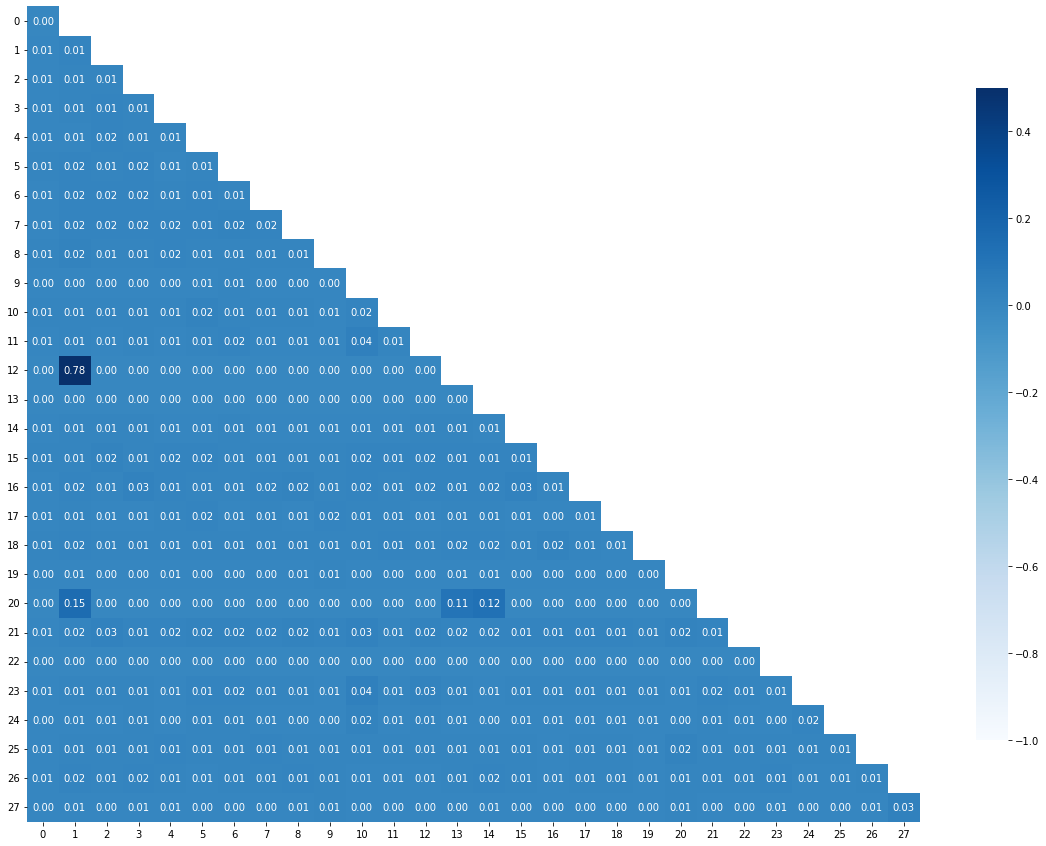

In [70]:
import seaborn as sb
fig, ax = plt.subplots(figsize=(20, 15))
# mask
mask = np.triu(np.ones_like(sMatrix, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = sMatrix[1:,:-1].copy()
# plot heatmap
sb.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='Blues',
           vmin=-1, vmax=0.5, cbar_kws={"shrink": .8})
# yticks
plt.yticks(rotation=0)
plt.show()